## Settings

In [1]:
import os

from langchain.document_loaders import UnstructuredFileLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

import torch
from torch import Tensor, device

from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel

from typing import List

from tqdm.auto import tqdm
from tqdm.autonotebook import trange

/Users/nezumikozo/Documents/workspace/rag-redis-demo/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_printoptions(precision=2)
torch.set_printoptions(sci_mode=False)

In [3]:
from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display

@register_cell_magic
def background_color(color, cell=None):
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)

    display(HTML('<img src onerror="{}">'.format(script)))

## Plain old text

In [4]:
def get_chunks(company_name: str):
    file_folder_path = f"pdf/{company_name}"
    doc = [os.path.join(file_folder_path, file) for file in os.listdir(file_folder_path)][0]  # Only the first doc

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500,
        chunk_overlap=200,
        add_start_index=True
    )

    loader = UnstructuredFileLoader(doc, mode="single", strategy="fast")
    chunks = loader.load_and_split(text_splitter)

    content = [f"Company: {company_name}. " + chunk.page_content for chunk in chunks]
    metadata = [chunk.metadata for chunk in chunks]

    return content, metadata

In [5]:
content, metadata = get_chunks(company_name="novo_nordisk")

In [6]:
for _idx, _content in enumerate(content):
    if "scope 1 emission" in _content.lower():
        print(_idx)

251
260
262
265


In [7]:
content[251]

"Company: novo_nordisk. 51,951\n\n42,138\n\n123.3%\n\n2020\n\n28,565\n\n42,138\n\n67.8%\n\nContents Introducing Novo Nordisk Strategic Aspirations Key risks Management Consolidated statements Additional information\n\nNote\n\n2022\n\n2021\n\nStatement of Environmental, Social and Governance (ESG) performance\n\nEnvironmental performance\n\nResources\n\nEnergy consumption for operations (1,000 GJ)\n\nShare of renewable power for production sites Water consumption for production sites (1,000 m3) Breaches of environmental regulatory limit values\n\nEmissions and waste Scope 1 emissions (1,000 tonnes CO2) Scope 2 emissions (1,000 tonnes CO2) Scope 3 emissions (1,000 tonnes CO2)1 Waste from production sites (tonnes)\n\n7.1\n\n7.1\n\n7.2\n\n7.3\n\n7.4\n\n7.4\n\n7.4\n\n7.5\n\n3,677\n\n100%\n\n3,918\n\n75\n\n76\n\n16\n\n2,041\n\n213,505\n\n3,387\n\n100%\n\n3,488\n\n12\n\n77\n\n16\n\nN/A\n\n180,806\n\nfor the year ended 31 December\n\nSocial performance\n\nPatients\n\nPatients reached with Novo

In [8]:
content[260]

'Company: novo_nordisk. In 2022, Scope 1 emissions decreased by 1% compared to 2021 due to an increase in usage of renewable energy sources as a result of two production facilities, in the US and France, having converted to using biogas. Scope 2 emissions were in line with 2021. In 2022, we have expanded our Scope 3 reporting to include all categories of emissions from the GHG protocol relevant to Novo Nordisk. The highest portion of Scope 3 emissions was in purchased goods and services and capital goods. These two categories together make up to 85% of the overall Scope 3 emissions.\n\n– Capital goods2\n\n– Fuel and energy related activities2\n\n– Upstream transportation and distribution2\n\n– Waste generated in operations2\n\n– Business travel\n\n– Employee commuting2\n\n477\n\n55\n\n123\n\n5\n\n55\n\n35\n\nN/A\n\nN/A\n\nN/A\n\nN/A\n\nN/A\n\nN/A\n\n– Downstream transportation and distribution2\n\n37\n\nN/A\n\n7.2 Water consumption for production sites\n\n– End-of-life treatment of sol

## Encoded text

In [9]:
default_embedder = SentenceTransformer(
    "sentence-transformers/msmarco-distilbert-base-tas-b", 
    cache_folder="cache"
)

In [10]:
encoded_content = default_embedder.encode(content[251])

In [11]:
encoded_content.shape

(768,)

In [12]:
encoded_content[:10]

array([-0.2132133 ,  0.11719614,  0.22745958, -0.29696494,  0.16332254,
        0.4249692 ,  0.2892638 , -0.5250201 ,  0.04183745, -0.41405323],
      dtype=float32)

<div style="background-color: honeydew">

## Why do we encode content in embedded space?
- Semantic search! Instead of searching by the face value of the exact words, embedded space can encode meanings, so we can see the forest for the trees.
- But do we need it? In which scenarios? Does number fit into this scenario?

</div>

## What is an encoder composed of?

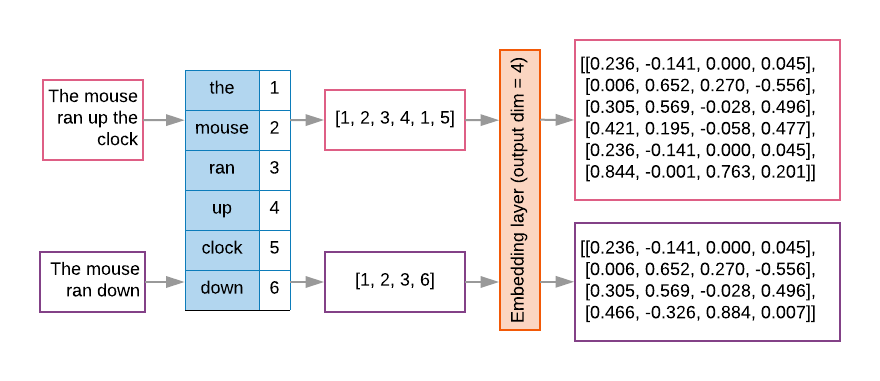

In [43]:
from IPython.display import Image
Image(filename='pix/embedding.png') 

### Component 1 - Tokenizer

In [14]:
def show_tokens(sentence: str, tokenizer):
    
    inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    print("Number of tokens:", len(inputs.input_ids[0]))
        
    for input_id in inputs.input_ids[0]:
        print(input_id, "->", tokenizer.decode(input_id))

In [15]:
default_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-tas-b")

In [16]:
show_tokens(sentence=content[251], tokenizer=default_tokenizer)

Number of tokens: 375
tensor(101) -> [CLS]
tensor(2194) -> company
tensor(1024) -> :
tensor(24576) -> novo
tensor(1035) -> _
tensor(13926) -> nord
tensor(20573) -> ##isk
tensor(1012) -> .
tensor(4868) -> 51
tensor(1010) -> ,
tensor(5345) -> 95
tensor(2487) -> ##1
tensor(4413) -> 42
tensor(1010) -> ,
tensor(15028) -> 138
tensor(13138) -> 123
tensor(1012) -> .
tensor(1017) -> 3
tensor(1003) -> %
tensor(12609) -> 2020
tensor(2654) -> 28
tensor(1010) -> ,
tensor(5179) -> 56
tensor(2629) -> ##5
tensor(4413) -> 42
tensor(1010) -> ,
tensor(15028) -> 138
tensor(6163) -> 67
tensor(1012) -> .
tensor(1022) -> 8
tensor(1003) -> %
tensor(8417) -> contents
tensor(10449) -> introducing
tensor(24576) -> novo
tensor(13926) -> nord
tensor(20573) -> ##isk
tensor(6143) -> strategic
tensor(22877) -> aspirations
tensor(3145) -> key
tensor(10831) -> risks
tensor(2968) -> management
tensor(10495) -> consolidated
tensor(8635) -> statements
tensor(3176) -> additional
tensor(2592) -> information
tensor(3602) -> 

### Component 2 - Encoder

In [17]:
def mean_pooling(model_output, attention_mask):
    # First element of model_output contains all token embeddings
    token_embeddings = model_output[0]  
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [18]:
# CLS Pooling - Take output from first token
def cls_pooling(model_output):
    return model_output.last_hidden_state[:,0]

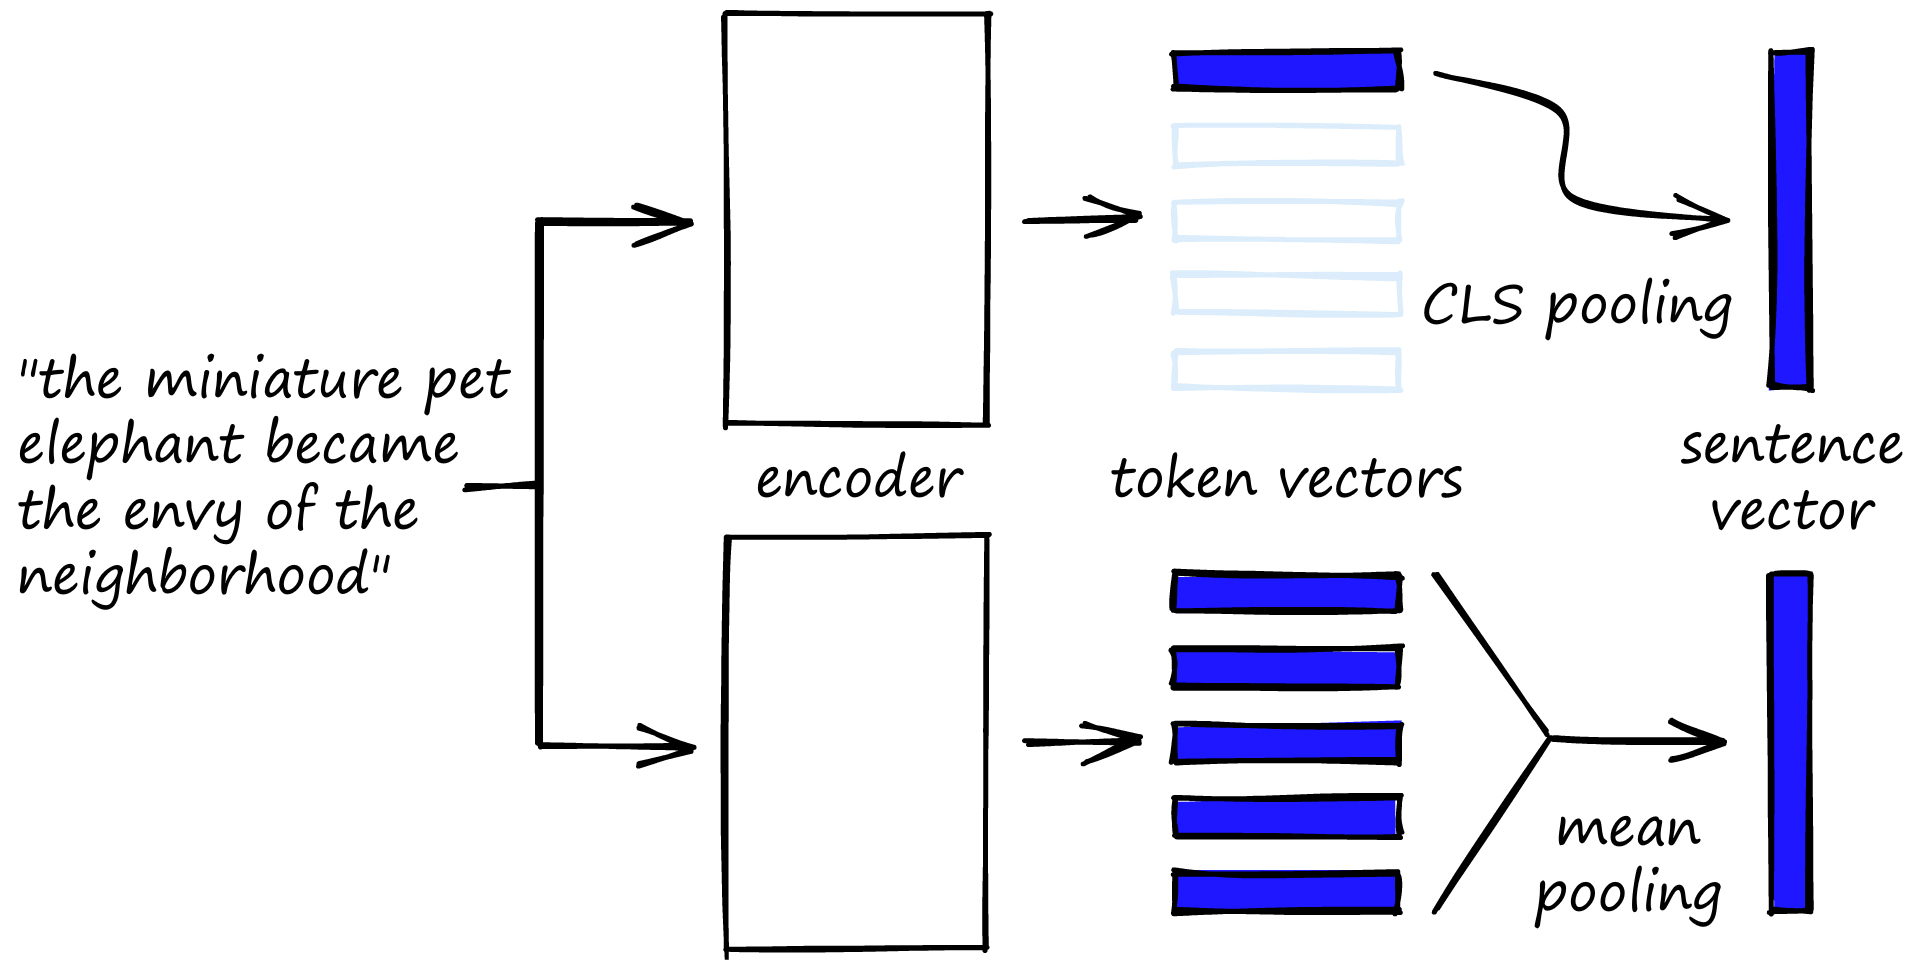

In [44]:
from IPython.display import Image
Image(filename='pix/pooling.png') 

In [20]:
def batch_to_device(batch, target_device: device):
    """
    send a pytorch batch to a device (CPU/GPU)
    """
    for key in batch:
        if isinstance(batch[key], Tensor):
            batch[key] = batch[key].to(target_device)
    return batch

In [21]:
def get_batched_embeddings(sentences: List[str], batch_size: int, tokenizer, model, device="cpu"):
    
    all_embeddings = []
    once = False
    
    for start_index in trange(0, len(sentences), batch_size):
        # 1. Tokenize sentences
        batch = sentences[start_index:start_index+batch_size]
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
        
        encoded_input = batch_to_device(encoded_input, device)
        
        with torch.no_grad():
            # 2. Compute token embeddings -> Same toke might have different embeddings due to context.
            model_output = model(**encoded_input)

            if once is False:
                print("Shape of embedded tokens:", model_output.last_hidden_state.shape)
                once = True

            # 3. Perform pooling
            # Option 1: Mean pooling
            # embeddings = mean_pooling(model_output, encoded_input.attention_mask)
            
            # Option 2: CLS pooling
            embeddings = cls_pooling(model_output)
            
            embeddings = embeddings.detach()
            all_embeddings.extend(embeddings)
    
    all_embeddings = torch.stack(all_embeddings)
    
    return all_embeddings

In [22]:
default_model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-tas-b")

In [23]:
batched_embeddings = get_batched_embeddings(
    sentences=[content[251]],
    batch_size=1,
    tokenizer=default_tokenizer,
    model=default_model
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]

Shape of embedded tokens: torch.Size([1, 375, 768])


In [24]:
batched_embeddings.shape

torch.Size([1, 768])

In [25]:
batched_embeddings[0].numpy()[:10]

array([-0.2132133 ,  0.11719614,  0.22745958, -0.29696494,  0.16332254,
        0.4249692 ,  0.2892638 , -0.5250201 ,  0.04183745, -0.41405323],
      dtype=float32)

In [26]:
util.cos_sim(encoded_content, batched_embeddings)

tensor([[1.00]])

<div style="background-color: honeydew">

### The factors influence embeddings:
- batch_size
- pooling method

</div>

## Search in embedded space

In [27]:
default_query = "what are scope 1 emissions?"
encoded_query = default_embedder.encode(default_query)

In [28]:
encoded_docs = default_embedder.encode(content)

In [29]:
def get_topk_similarity(k, encoded_query, encoded_docs, is_cos_sim, debug):

    if is_cos_sim:
        # Compute cosine similarity between query and all document embeddings
        cos_sim = util.cos_sim(encoded_query, encoded_docs)
        
        # Combine docs & scores
        doc_idx_score_pairs = list(zip(range(len(encoded_docs)), cos_sim[0].tolist()))  # The first query

    else:
        # Compute dot score between query and all document embeddings
        scores = util.dot_score(encoded_query, encoded_docs)[0].tolist()

        # Combine docs & scores
        doc_idx_score_pairs = list(zip(range(len(encoded_docs)), scores))
    
    # Sort by decreasing score
    doc_idx_score_pairs = sorted(doc_idx_score_pairs, key=lambda x: x[1], reverse=True)

    if debug:
        print(f"Most similar pairs:\ndoc_idx\t score")
        for doc_idx, score in doc_idx_score_pairs[:k]:
            print(f"{doc_idx} \t {score:.4f}")
    else:
        return doc_idx_score_pairs[:k]

In [30]:
get_topk_similarity(
    k=10, 
    encoded_query=encoded_query, 
    encoded_docs=encoded_docs, 
    is_cos_sim=True,
    debug=True,
)

Most similar pairs:
doc_idx	 score
260 	 0.8382
262 	 0.8159
261 	 0.8079
259 	 0.7817
19 	 0.7793
265 	 0.7757
23 	 0.7705
22 	 0.7657
21 	 0.7652
266 	 0.7557


In [31]:
get_topk_similarity(
    k=10, 
    encoded_query=encoded_query, 
    encoded_docs=encoded_docs, 
    is_cos_sim=False,
    debug=True,
)

Most similar pairs:
doc_idx	 score
260 	 103.9198
261 	 102.3122
21 	 101.1397
262 	 100.4351
259 	 100.2170
20 	 98.4837
23 	 98.0990
19 	 97.9896
22 	 97.5419
265 	 95.7639


In [32]:
content[21]

'Company: novo_nordisk. emissions from transportation, as supply chain constraints\n\nGSK, Merck KGaA, Roche, Sanofi, as well as the\n\nhave forced us to increase our use of airfreight to ensure\n\nWorld Health Organization (WHO), UNICEF, NHS\n\nEmissions from operations and transportation (1,000 tonnes CO2) Target 2030: zero emissions from operations and transportation\n\ntimely delivery of our medicines to patients globally. Due to\n\nour extensive supply chain, we have a target for all our 60,000+\n\nEngland and leading health research institutions.\n\nWhile initiated by HRH King Charles III in the UK, the\n\nsuppliers, to be reached by 2030, to source 100% renewable\n\npartnership is global in scope.\n\n350\n\n306\n\npower when supplying us. Already more than 500 of our key\n\n300\n\nsuppliers have committed to source renewable power, which\n\nBy agreeing on a set of concrete commitments and\n\n250\n\n200\n\n150\n\n170\n\n174\n\n218\n\nCompany cars (Scope 1)\n\nBusiness flights (Sc

In [33]:
content[261]

'Company: novo_nordisk. 1. The calculation of Scope 3 emissions is substantially based on estimations\n\nand therefore inherently uncertain.\n\n2. Categories measured in CO2 equivalents (CO2e).\n\nProduction sites in France, Brazil, China, Iran and Algeria are located in areas subject to water stress or high seasonal variations (please refer to the CDP Water Security 2022 Reporting Guidance). They consume 13% of the total water for global production. Overall, water consumption at these facilities increased by 7% compared to 2021 due to an increase in production volumes. Implementation of water conservation projects in water-stressed areas led to savings of 6 thousand cubic meters of water.\n\nAccounting policies Water consumption is measured based on meter readings and invoices. It includes drinking water, industrial water and steam water used at production sites.\n\nAccounting policies Scope 1 and 2 emissions are limited to CO2 emissions from energy and do not include other greenhouse

## What is the score for the correct answer?

In [34]:
result_pairs = get_topk_similarity(
    k=100, 
    encoded_query=encoded_query, 
    encoded_docs=encoded_docs, 
    is_cos_sim=True,
    debug=False
)

In [35]:
answer_pair = [(ranking, result_pair) for (ranking, result_pair) in enumerate(result_pairs) if result_pair[0] == 251]

In [36]:
answer_pair

[(17, (251, 0.7210701107978821))]

<div style="background-color: honeydew">
    
### Why is the correct answer matchting almost all the exact words ranked so low?
- The chunk is too long, thus it contains irrelevant content which interferes with its meaning and context?

</div>

## What are the other options?

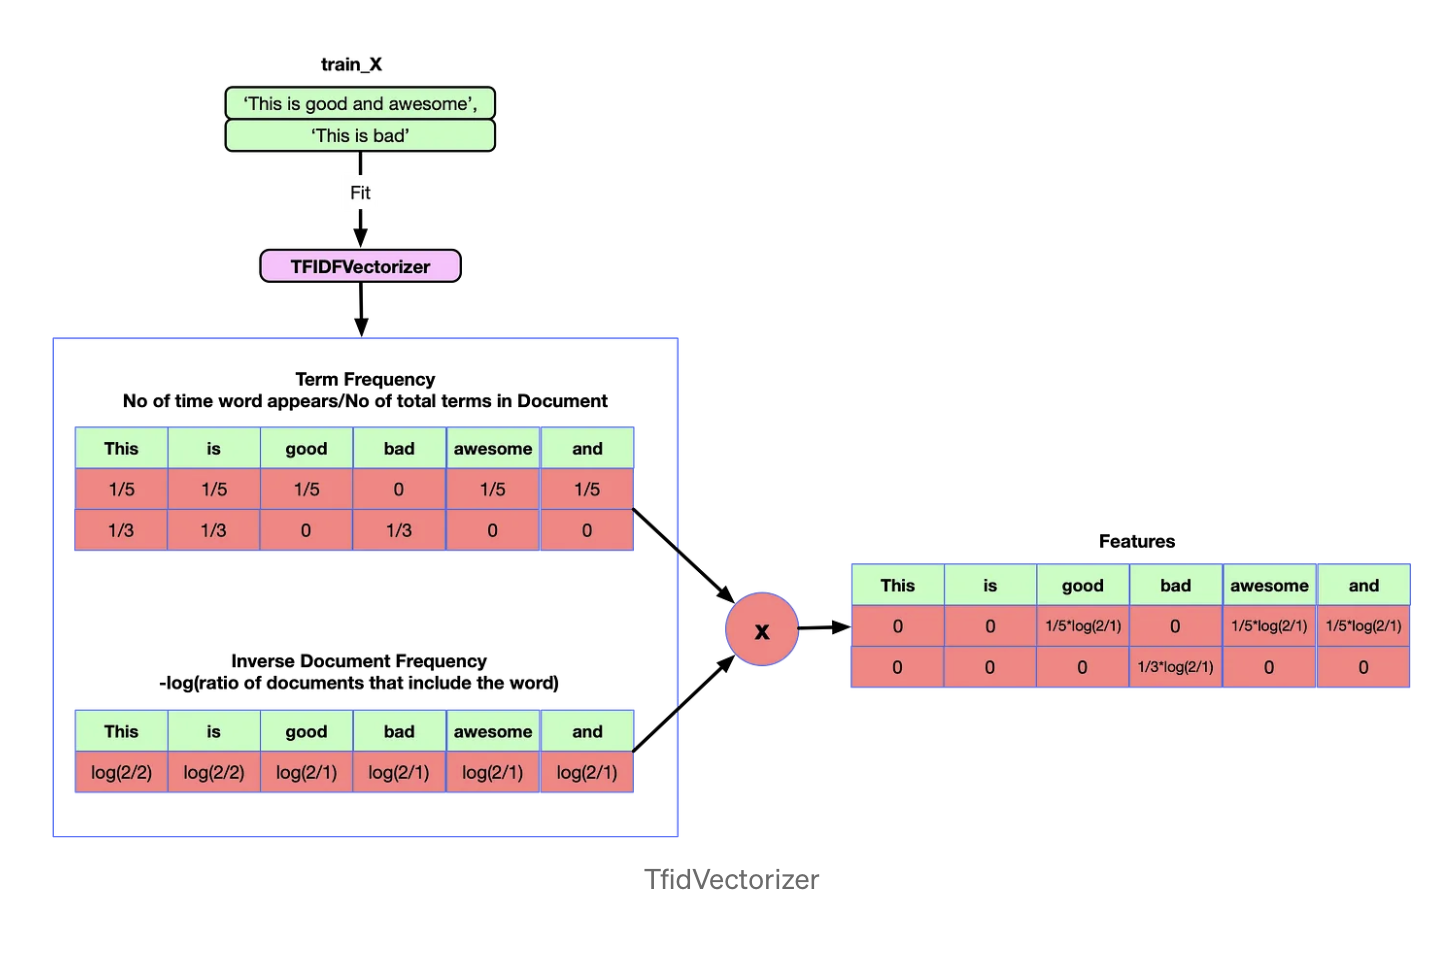

In [45]:
from IPython.display import Image
Image(filename='pix/tfidf.png') 

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize an instance of tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Generate the tf-idf vectors for the docs
content_matrix = tfidf_vectorizer.fit_transform(content)

# Generate the tf-idf vectors for the query
query_matrix = tfidf_vectorizer.transform([default_query])

In [39]:
content_matrix.shape

(327, 5651)

In [40]:
query_matrix.shape

(1, 5651)

In [41]:
def get_topk_tfidf_similarity(k, encoded_query, encoded_docs, debug):

    cos_sim = cosine_similarity(encoded_query, encoded_docs)

    doc_idx_score_pairs = list(zip(range(content_matrix.shape[0]), cos_sim[0].tolist()))  # The first query
    doc_idx_score_pairs = sorted(doc_idx_score_pairs, key=lambda x: x[1], reverse=True)

    if debug:
        print(f"Most similar pairs:\ndoc_idx\t score")
        for doc_idx, score in doc_idx_score_pairs[:k]:
            print(f"{doc_idx} \t {score:.4f}")
    else:
        return doc_idx_score_pairs[:k]

In [42]:
get_topk_tfidf_similarity(
    k=10, 
    encoded_query=query_matrix, 
    encoded_docs=content_matrix,
    debug=True,
)

Most similar pairs:
doc_idx	 score
22 	 0.4045
262 	 0.3848
260 	 0.3026
265 	 0.2394
19 	 0.2335
20 	 0.2172
21 	 0.1979
264 	 0.1916
263 	 0.1858
251 	 0.1646
